In [1]:
import sys
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

In [2]:
sys.path.append('../')

In [3]:
from sys_utils import load_model
from data_model_region import Region
from data_model import Individual
import typing as t
import random

In [4]:
checkpoint_path = '../checkpoints_dev'

In [5]:
regions = load_model(
        Region, name=checkpoint_path+"/regions.jsonl"
    )

In [6]:
individuals = load_model(
        Individual, name=checkpoint_path + "/individuals.jsonl"
    )

In [7]:
manual = pd.read_csv('Manual_data/Cultural Index -  occupations work - fondamental.csv')
manual = manual.set_index('index')
manual = manual.drop('occupation', axis=1)
manual = manual.unstack().reset_index()
manual.columns = ['category', 'occupation', 'presence']
df_occupation_fondamental = manual.dropna().reset_index(drop=True)
df_occupation_fondamental = df_occupation_fondamental.drop('presence', axis=1)

In [8]:
df_occupation_fondamental

,category,occupation
0,Math and Phys sciences,mathematician
1,Math and Phys sciences,astronomer
2,Math and Phys sciences,physicist
3,Math and Phys sciences,chemist
4,Math and Phys sciences,mineralogist
5,Life sciences,botanist
6,Life sciences,naturalist
7,Life sciences,entomologist
8,Life sciences,zoologist
9,Life sciences,anatomist


In [79]:
def get_math_phys_index(individuals: t.List[Individual], df_occupation_fondamental:pd.DataFrame()):

    indiv = [x for x in individuals if x.regions != None]

    df = [
        {
            "wiki_id": x.id.wikidata_id,
            "name": x.id.name,
            "birthyear": x.id.birthyear,
            "region_code": x.regions,
            "range_impact": x.impact_years,
            "occupation": [y.name for y in x.id.occupations],
        }
        for x in indiv
    ]

    df = pd.DataFrame(df)
    df_explode = df.explode('occupation')
    df_merge = pd.merge(df_explode, df_occupation_fondamental, on = 'occupation')

    df_merge['math_phys_score'] = 0
    df_merge['math_phys_score'][df_merge['category']=='Math and Phys sciences'] = 1

    df_fig = df_merge.explode("region_code")

    df_fig["year"] = df_fig["range_impact"].apply(
            lambda x: [year for year in range(int(x[0]), int(x[1]) + 10, 10)]
        )
    df_fig = df_fig.explode("year")

    df_len = df_fig.groupby(["region_code", "year"])['wiki_id'].count().reset_index()
    df_sum = df_fig.groupby(["region_code", "year"])['math_phys_score'].sum().reset_index()

    df_final = pd.merge(df_len, df_sum, on = ['region_code', 'year'])
    df_final['math_phys_index'] = df_final['math_phys_score']/df_final['wiki_id']

    return df_final

In [134]:
df_math_phys = get_math_phys_index(individuals, df_occupation_fondamental)

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_39824/3081362045.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [135]:
df_math_phys = df_math_phys[df_math_phys['wiki_id']>=3]

In [137]:
df_trend = df_math_phys.copy()
df_trend = df_trend.rename(columns = {'math_phys_index':'cultural_score'})
df_trend = df_trend.drop(['wiki_id', 'math_phys_score'], axis=1)

In [138]:
import plotly.express as px

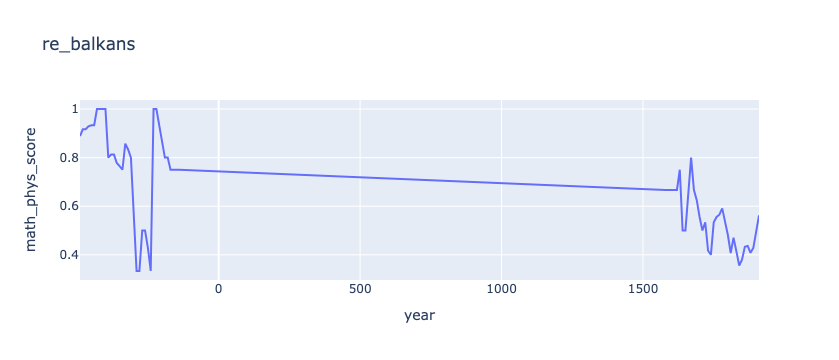

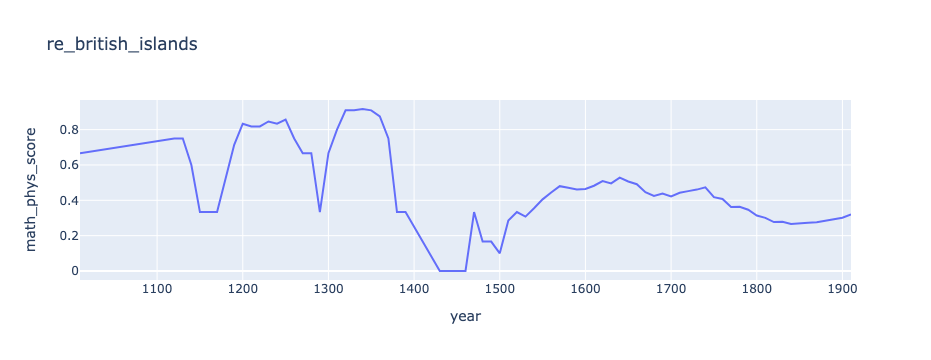

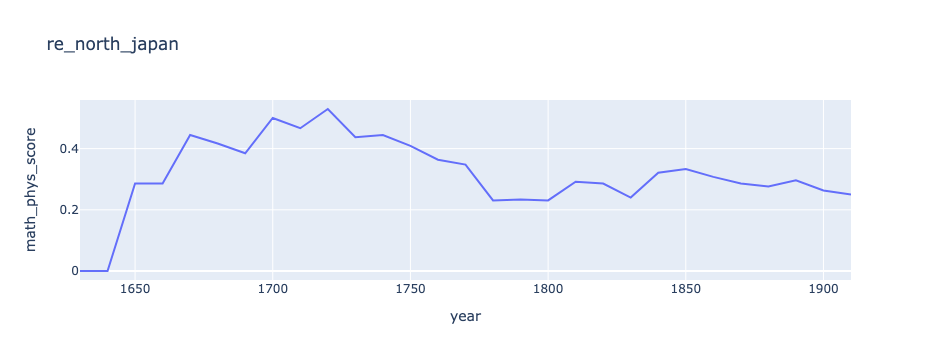

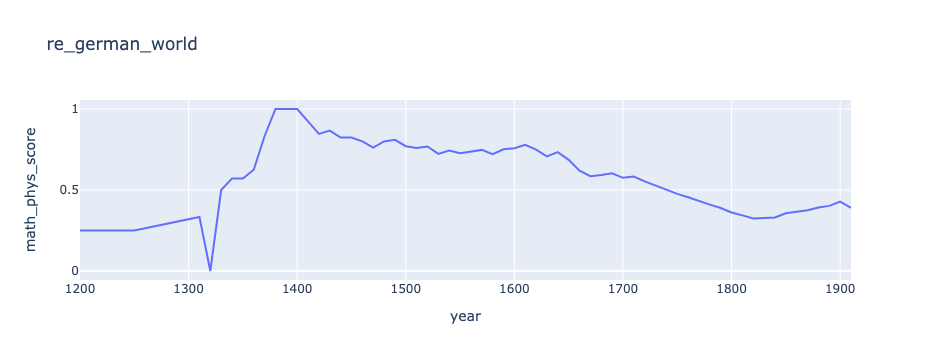

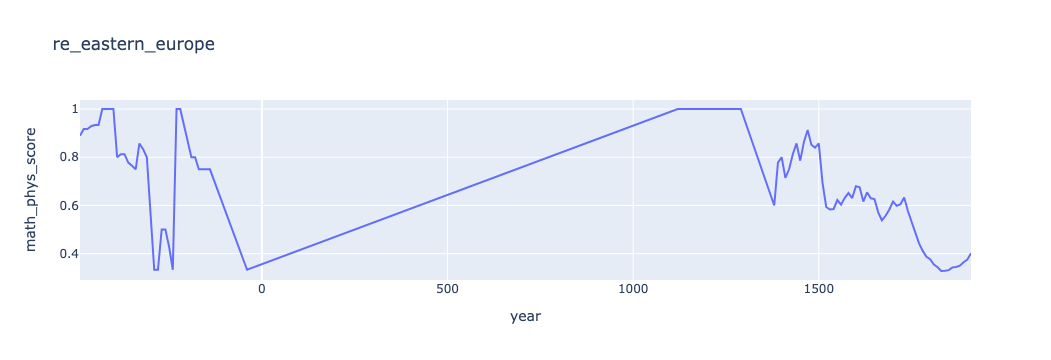

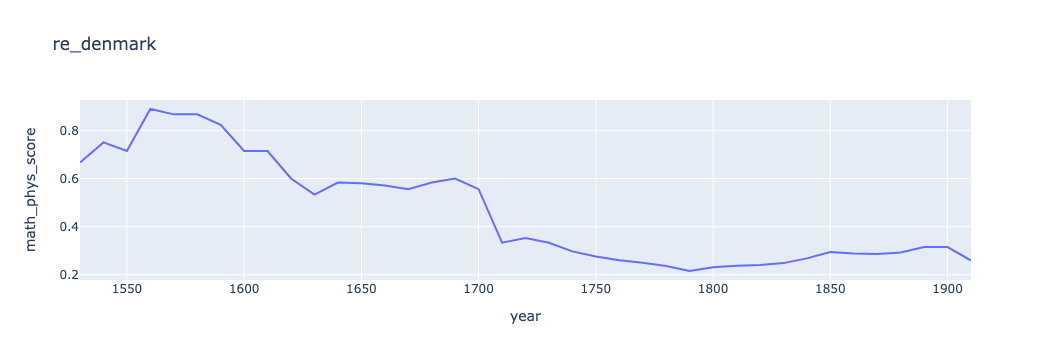

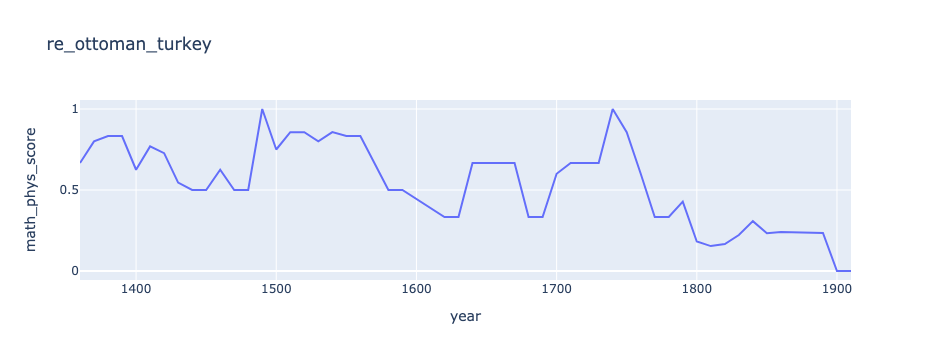

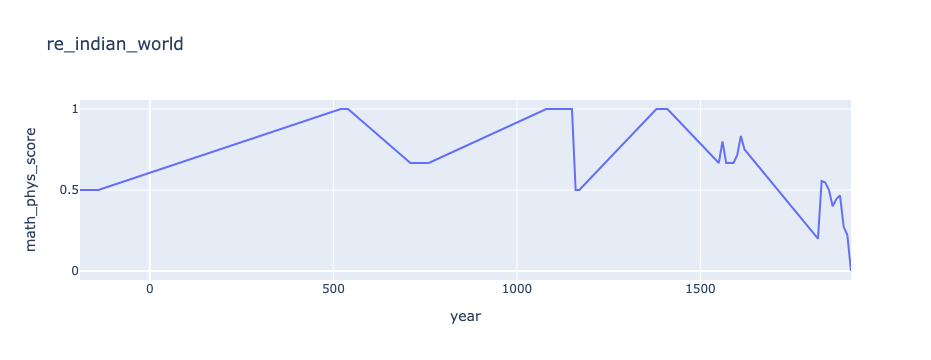

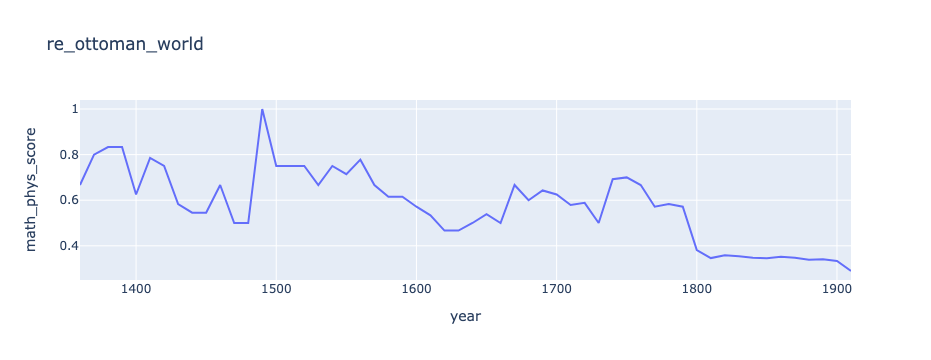

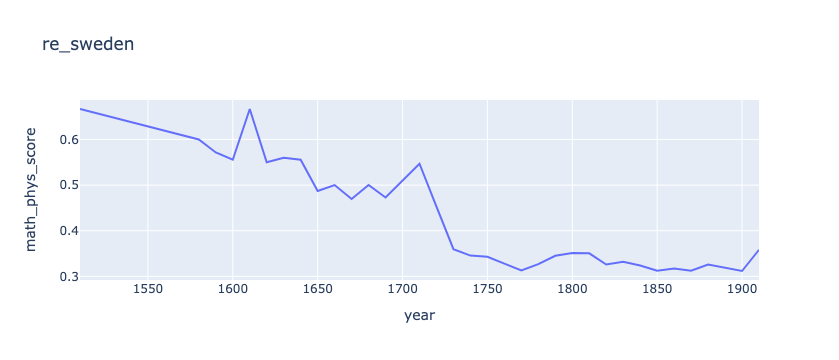

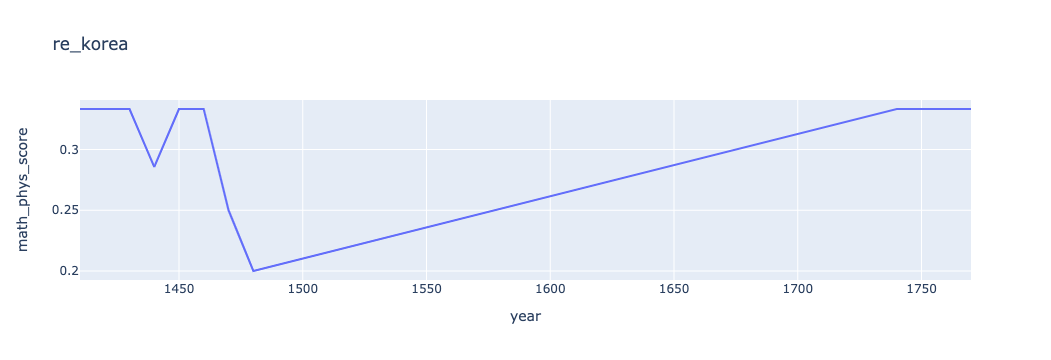

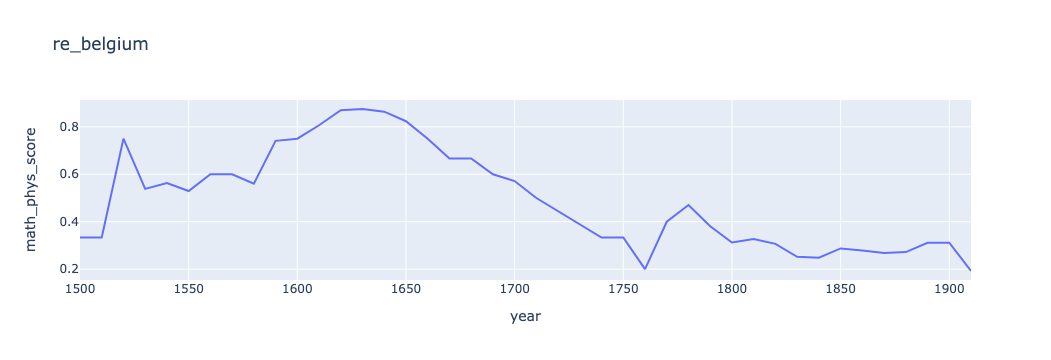

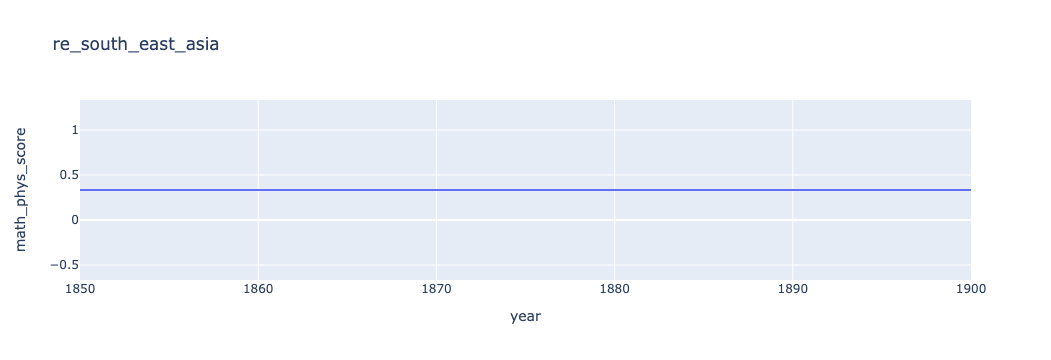

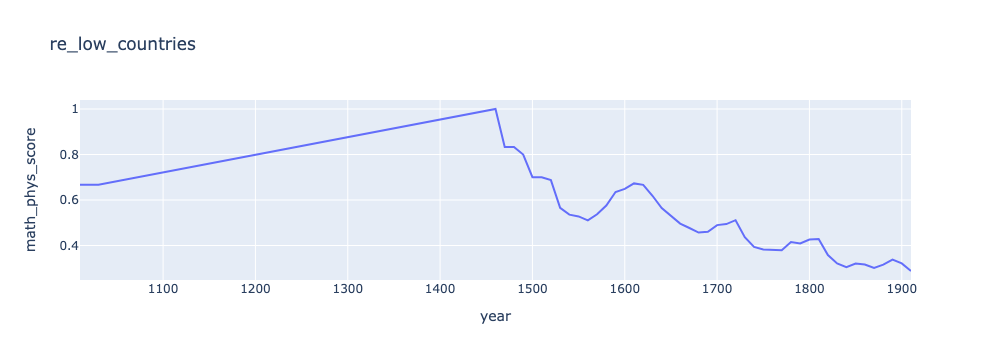

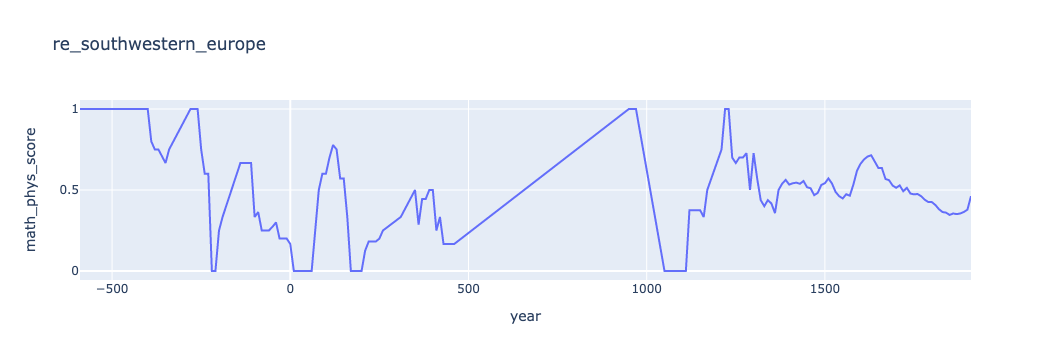

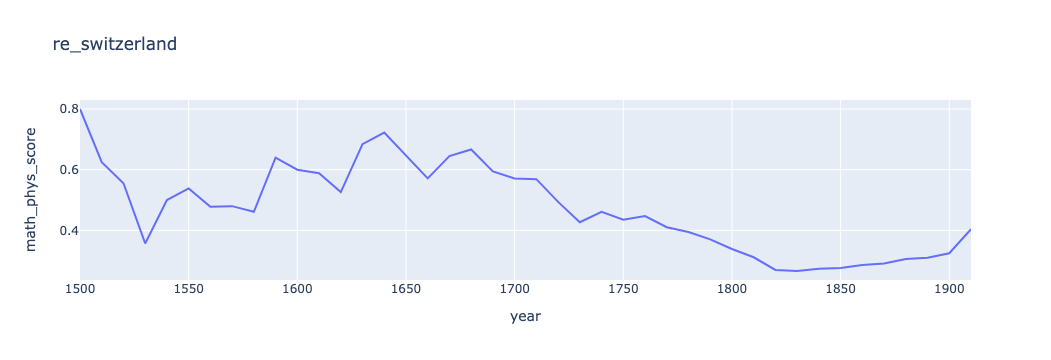

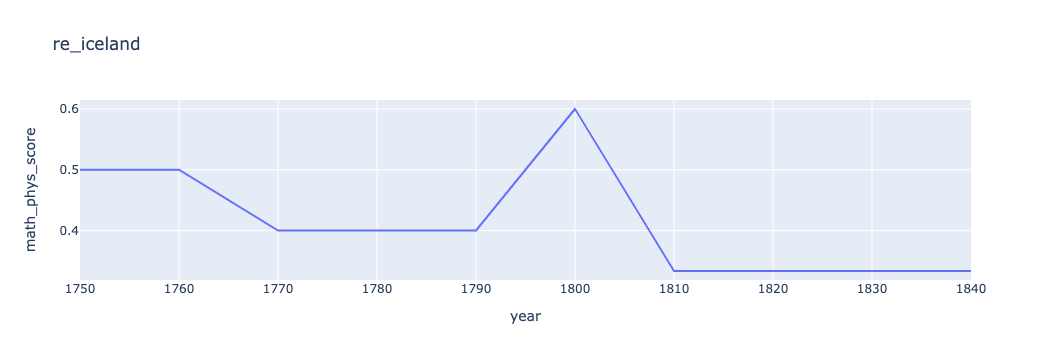

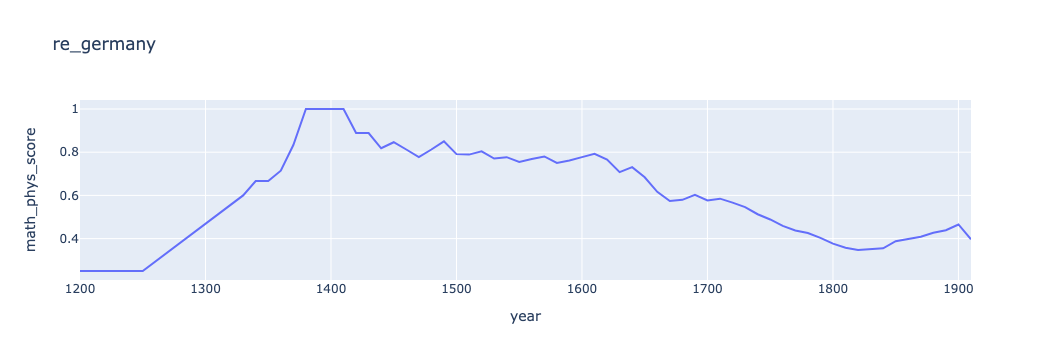

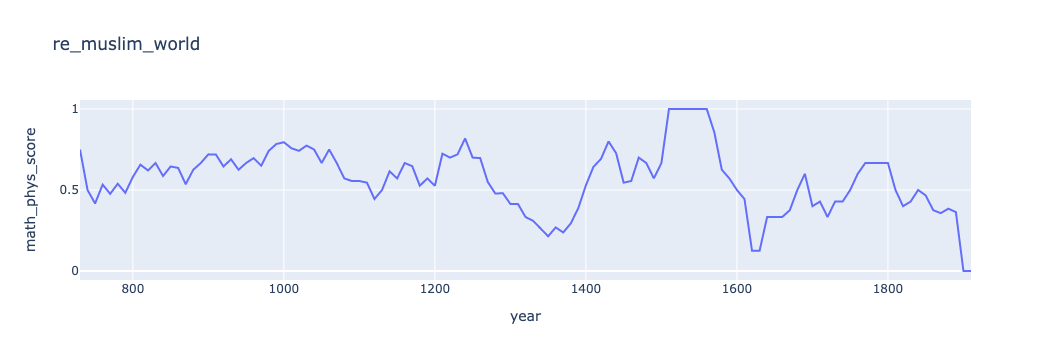

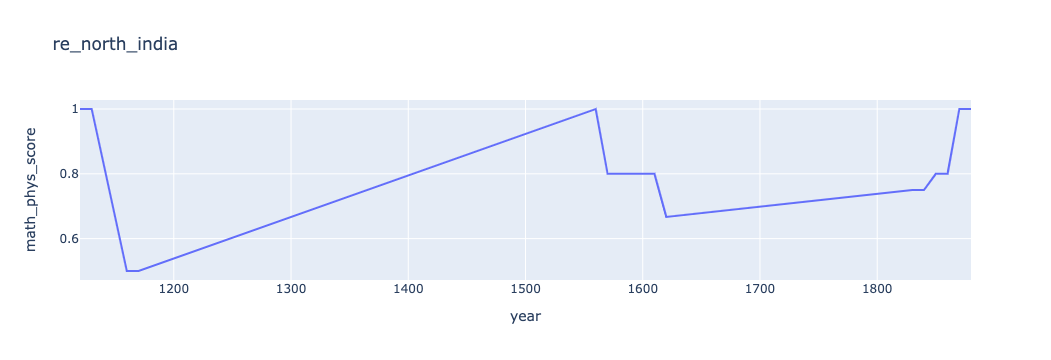

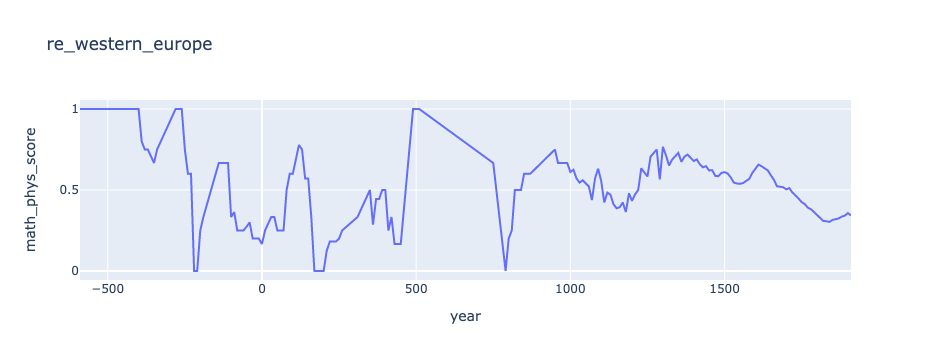

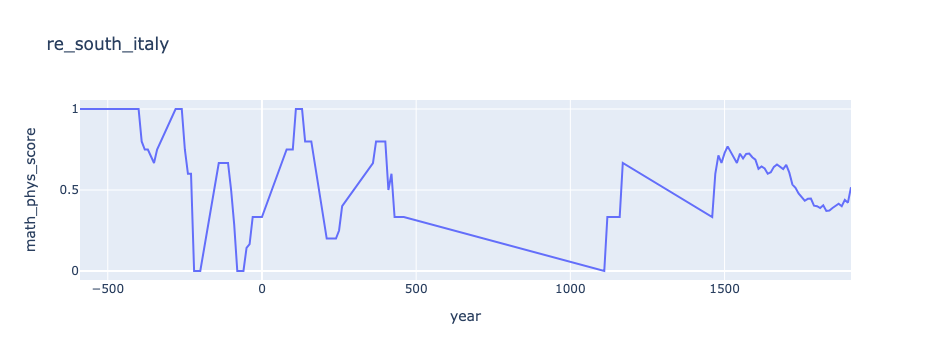

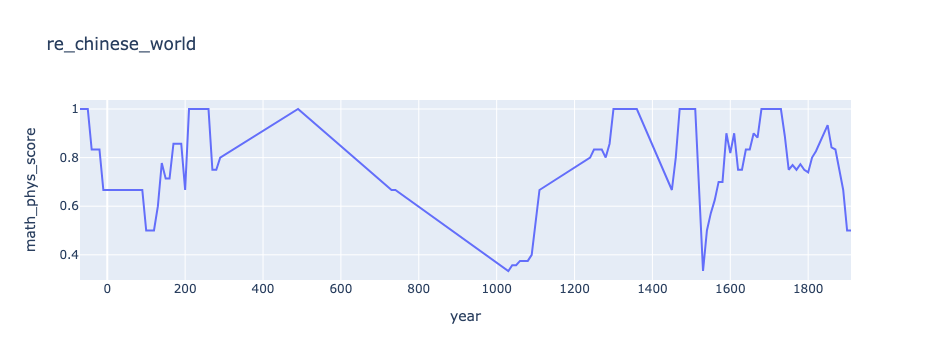

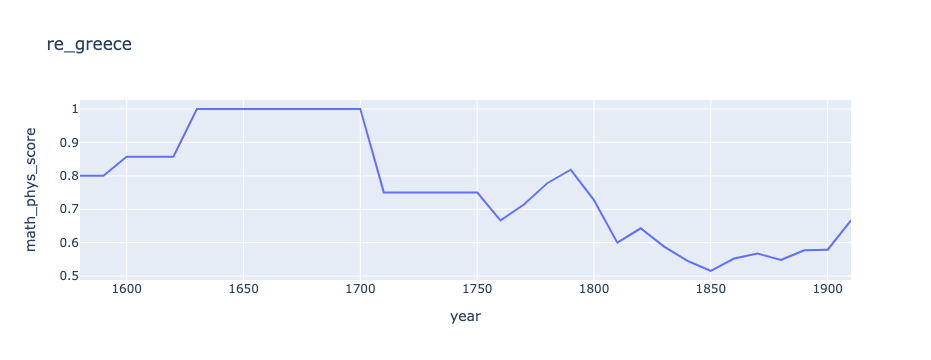

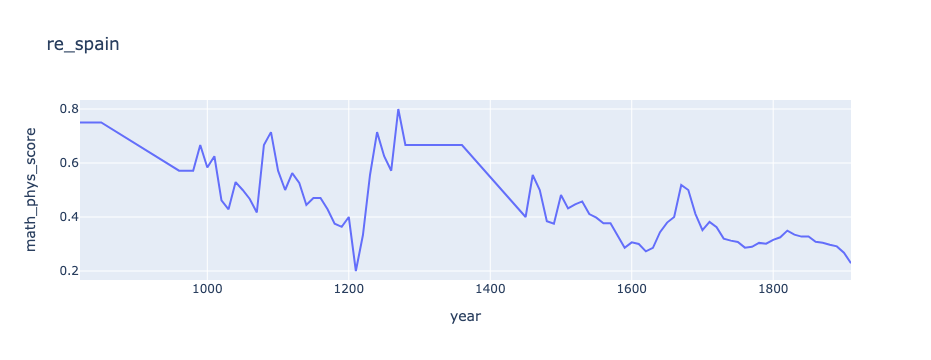

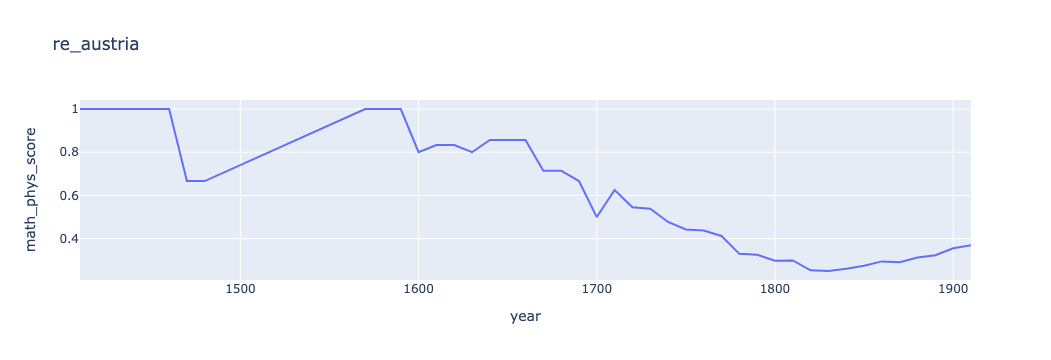

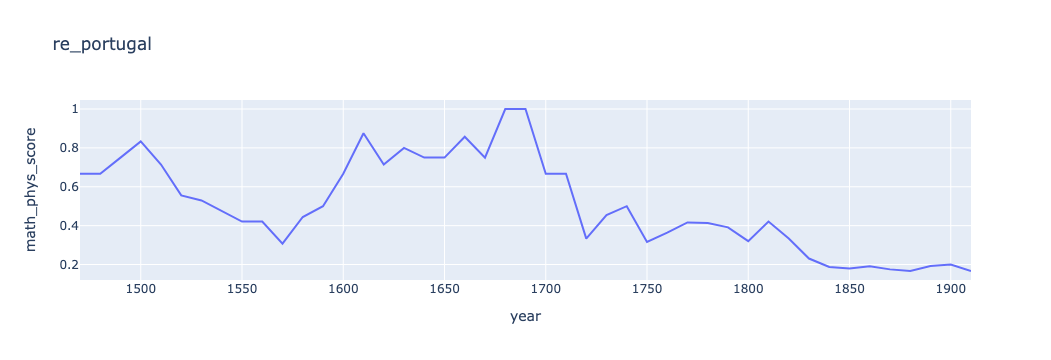

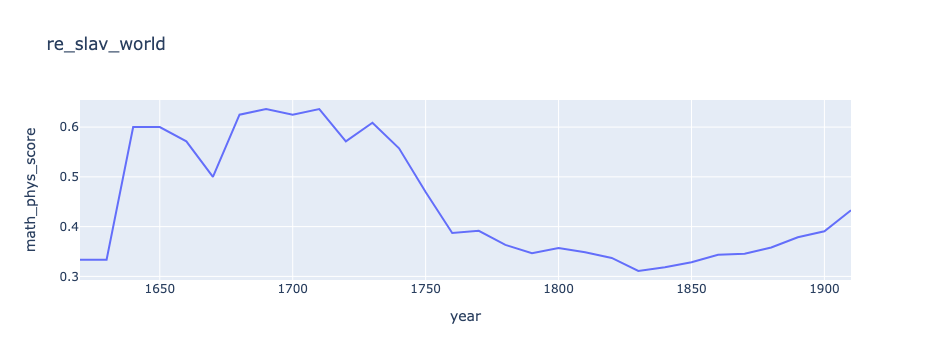

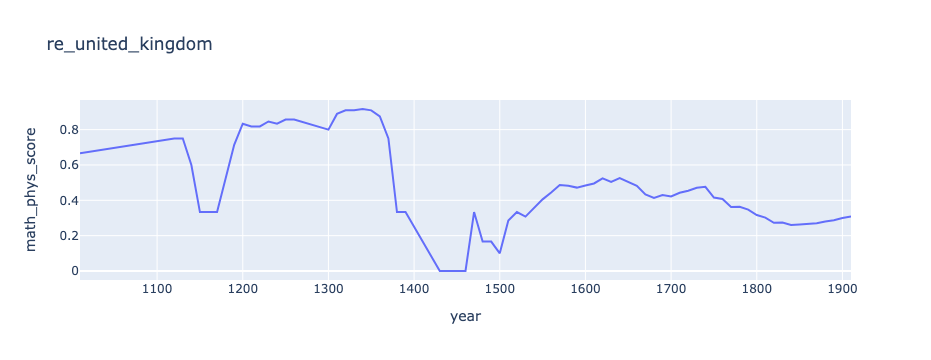

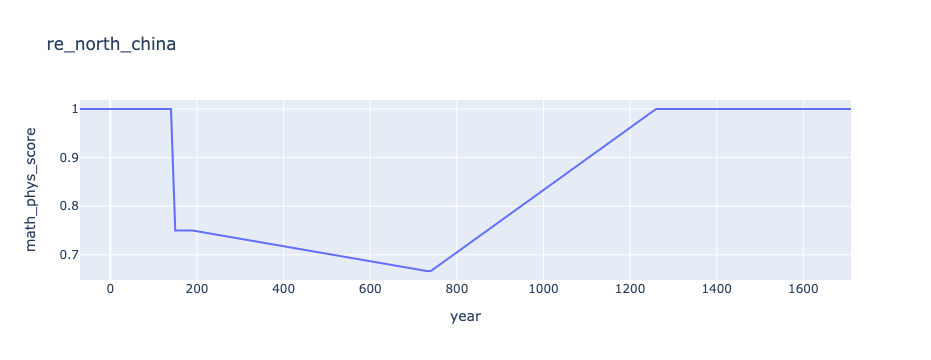

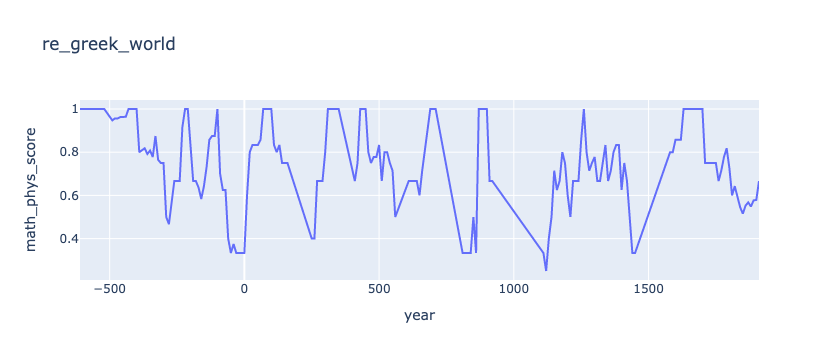

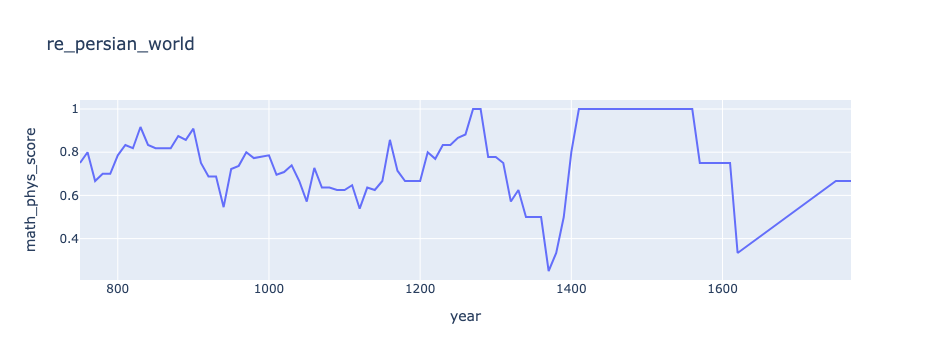

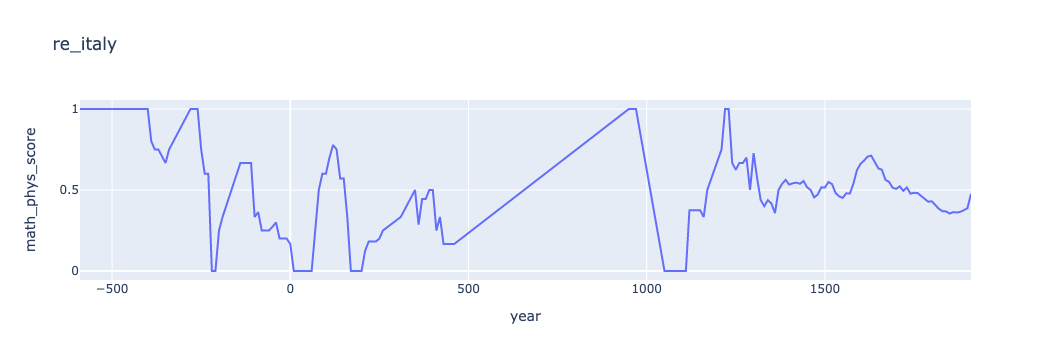

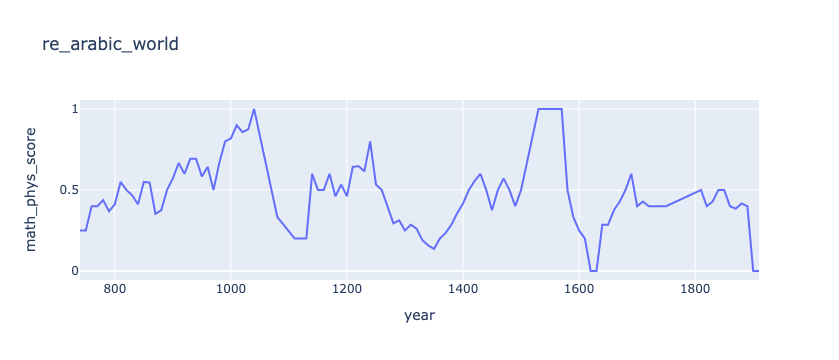

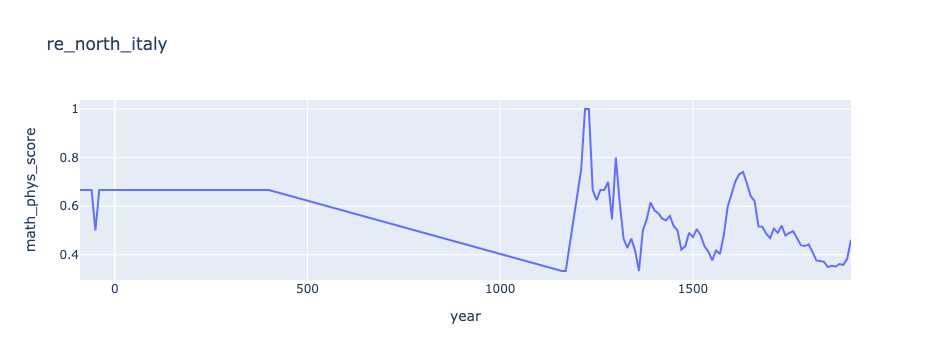

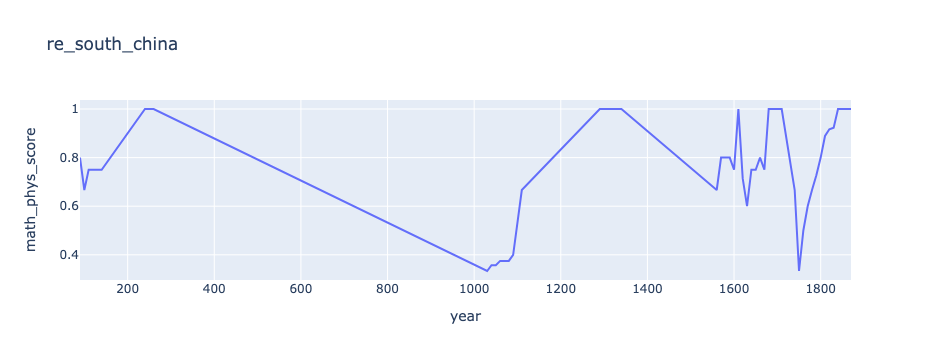

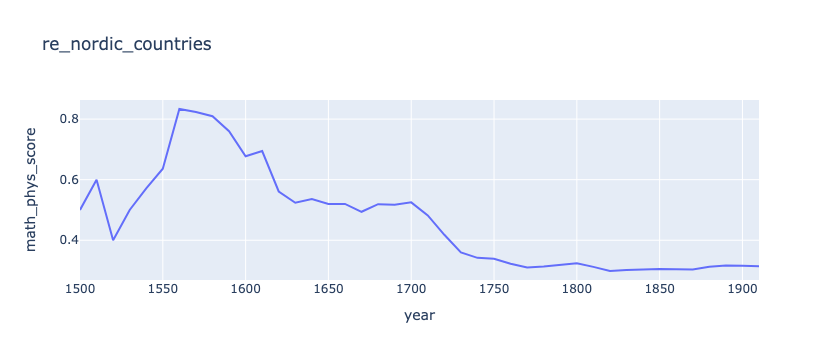

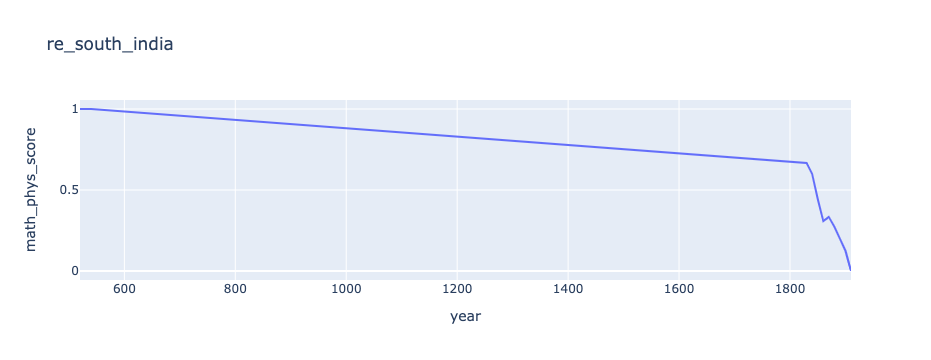

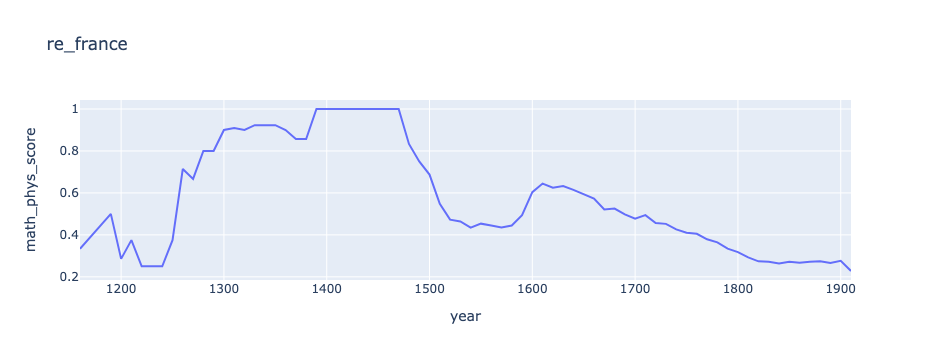

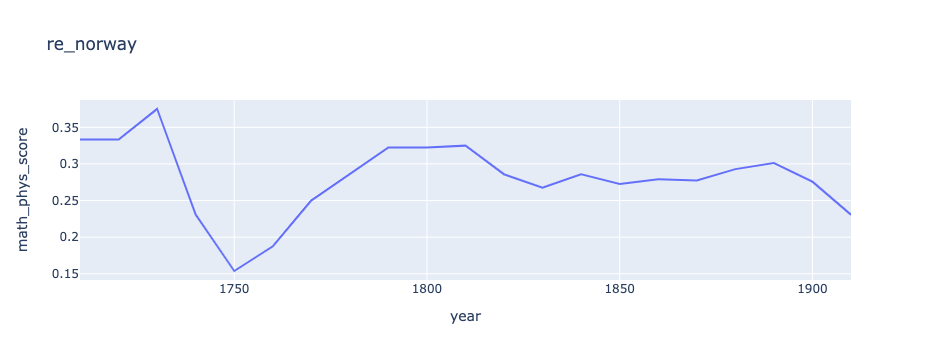

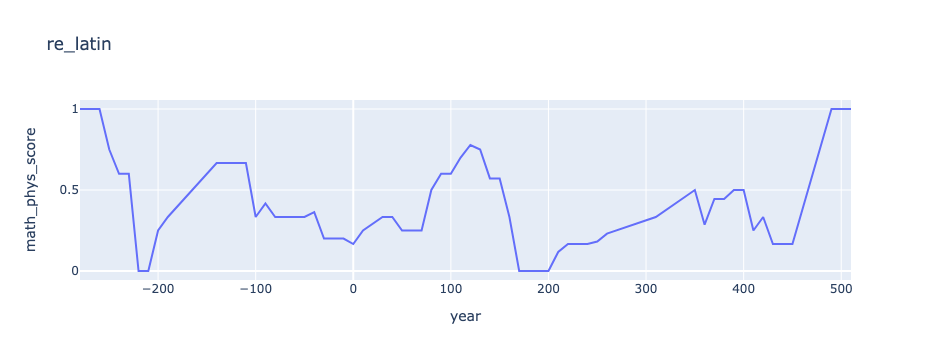

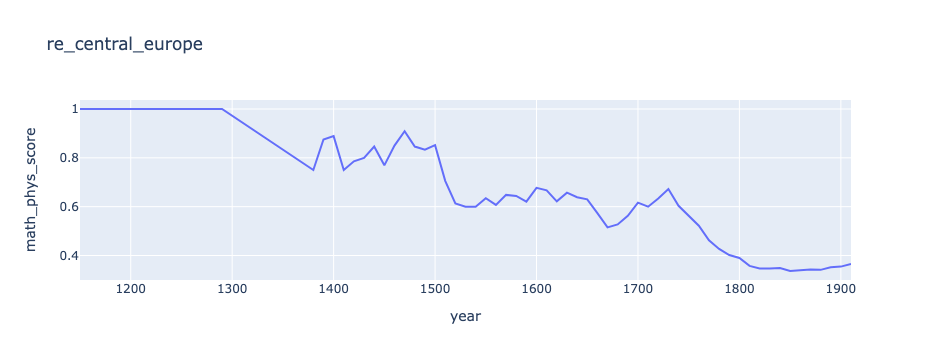

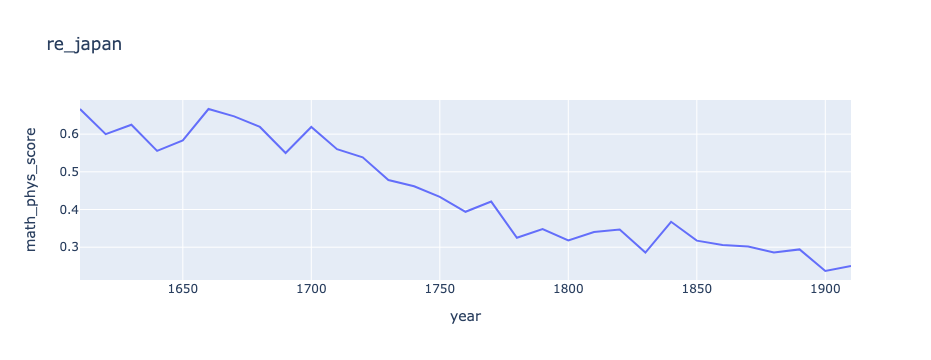

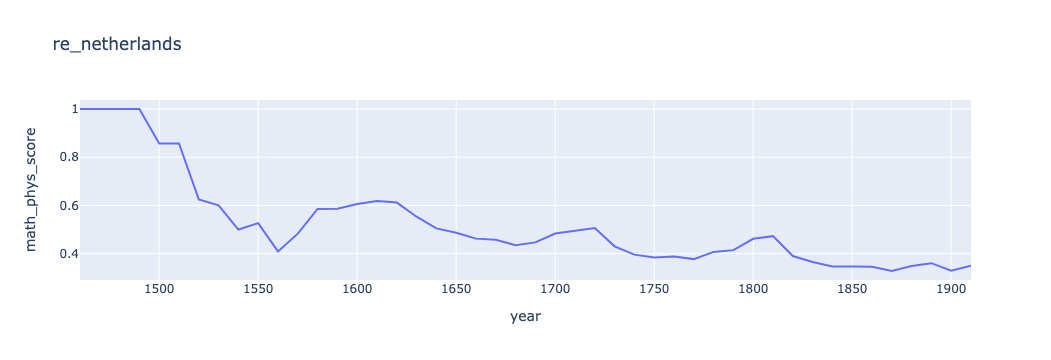

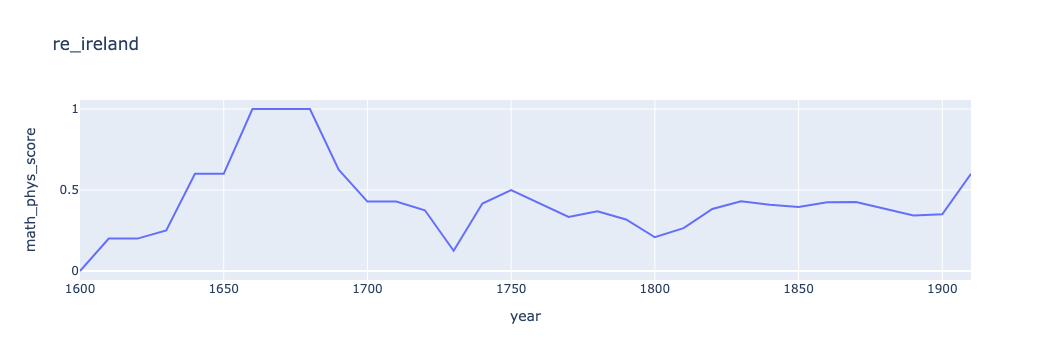

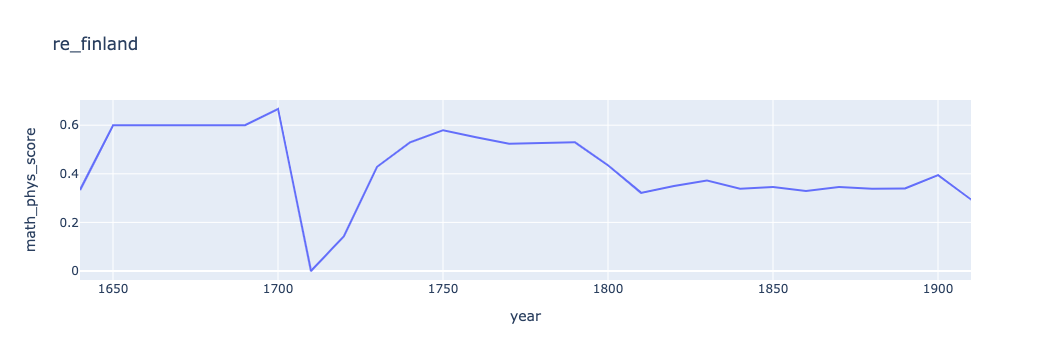

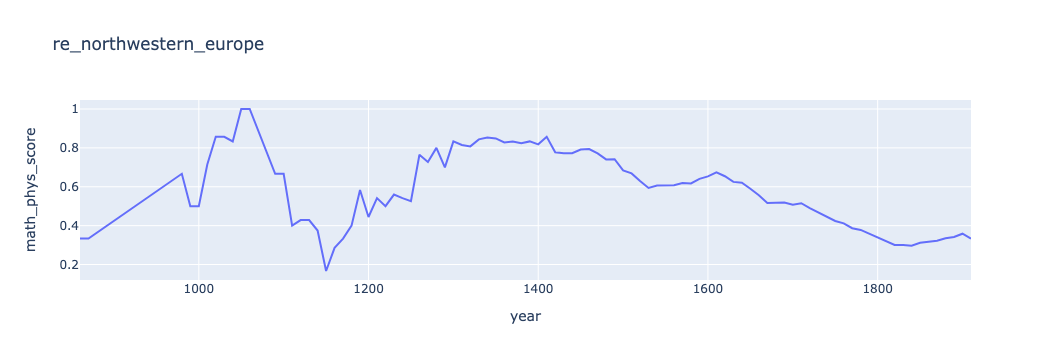

In [140]:
for region in set(df_trend.region_code):
    df_test = df_trend[df_trend['region_code']==region]
    df_test = df_test.rename(columns = {'cultural_score':'math_phys_score'})
    fig = px.line(df_test, x = 'year', y = 'math_phys_score', title = region)
    fig.show()

In [141]:
from functions_environment import get_maddison_data, get_population

In [142]:
data_path_environment = '../data_env'

In [143]:
df_maddison = get_maddison_data(data_path_environment)
df_maddison = df_maddison.drop('country_code_maddison', axis=1)

df_population = get_population(data_path_environment)

In [144]:
year_range = np.arange(-1000, 1850, 1)
df_year = pd.DataFrame(year_range, columns = ['year']).reset_index(drop=True)


df_trend_interpolated_list = []
for reg in set(df_trend['region_code']):

    res = df_trend[df_trend['region_code']==reg]
    res = pd.merge(res, df_year, on = 'year', how = 'outer')
    res['region_code'] = reg
    res = res.sort_values('year', ascending=True
                         )
    res['cultural_score_interpolared'] = res['cultural_score'].interpolate(method='linear')
    res = res.reset_index(drop=True)
    res = res[~res['cultural_score_interpolared'].isna()]

    df_trend_interpolated_list.append(res)
    
df_trend_interpolated = pd.concat([x for x in df_trend_interpolated_list])
df_trend_interpolated = df_trend_interpolated.reset_index(drop=True)

In [145]:
df_pop_interpolated_list = []
for reg in set(df_population['region_code']):

    res = df_population[df_population['region_code']==reg]
    res = pd.merge(res, df_year, on = 'year', how = 'outer')
    res['region_code'] = reg
    res = res.sort_values('year', ascending=True
                         )
    res['population_interpolated'] = res['value'].interpolate(method='linear')
    res = res.reset_index(drop=True)
    res = res[~res['population_interpolated'].isna()]

    df_pop_interpolated_list.append(res)
    
df_pop_interpolated = pd.concat([x for x in df_pop_interpolated_list])
df_pop_interpolated = df_pop_interpolated.reset_index(drop=True)

In [146]:
final_df = pd.merge(df_trend_interpolated, df_maddison, on = ['region_code', 'year'])
final_df = pd.merge(final_df, df_pop_interpolated, on = ['region_code', 'year'])

final_df = final_df.drop(['cultural_score', 'value'], axis=1)

In [147]:
final_df = final_df.rename(columns = {'cultural_score_interpolared':'math_phys_score_interpolared'})

In [148]:
final_df.to_csv('../data_stats/data_stats_math_phys_1003.csv')